# Modeling Sequential Data Using Recurrent Neural Networks


In [1]:
from IPython.display import Image

# Introducing sequential data

## Modeling sequential data⁠—order matters

## Representing sequences


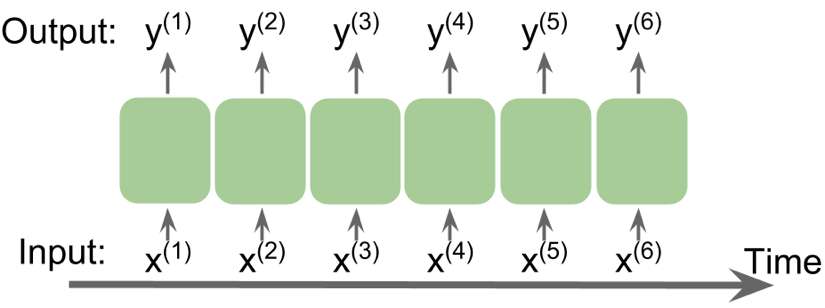

In [2]:
Image(filename='figures/15_01.png', width=700)

## The different categories of sequence modeling


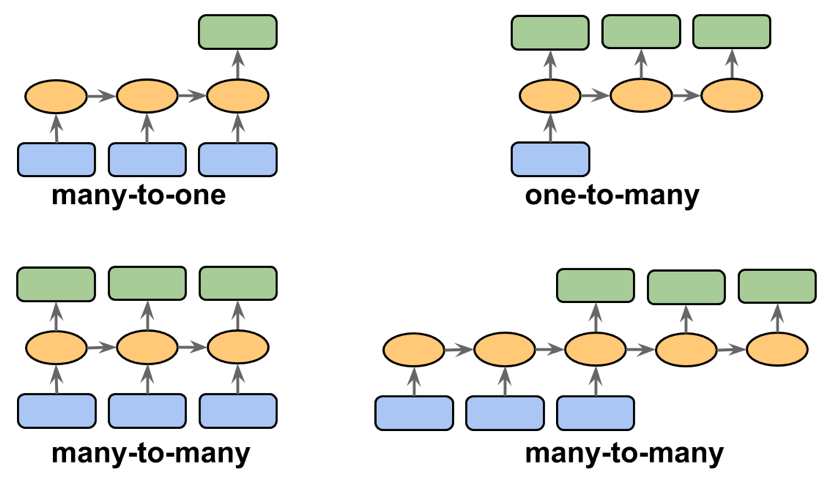

In [3]:
Image(filename='figures/15_02.png', width=700)

# RNNs for modeling sequences

## Understanding the RNN looping mechanism


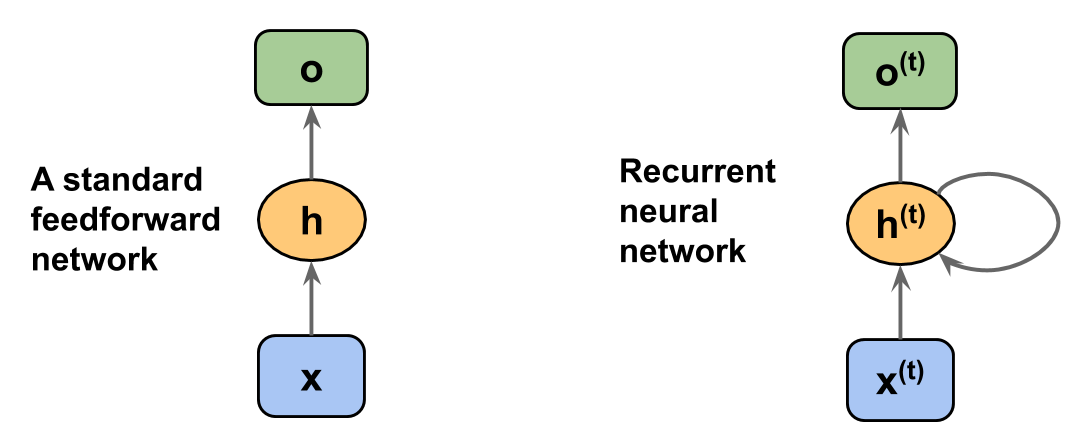

In [4]:
Image(filename='figures/15_03.png', width=700)

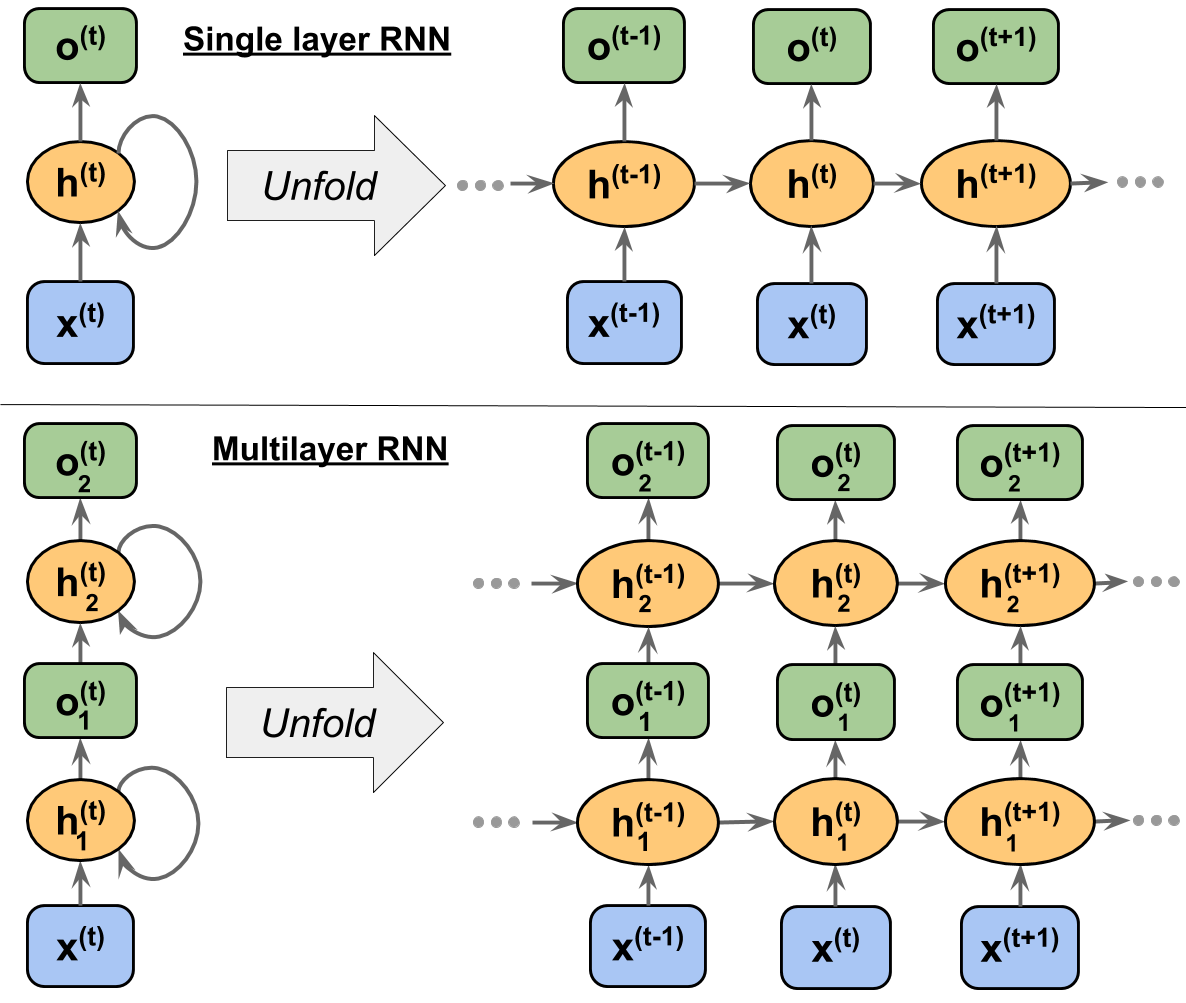

In [5]:
Image(filename='figures/15_04.png', width=700)

## Computing activations in an RNN


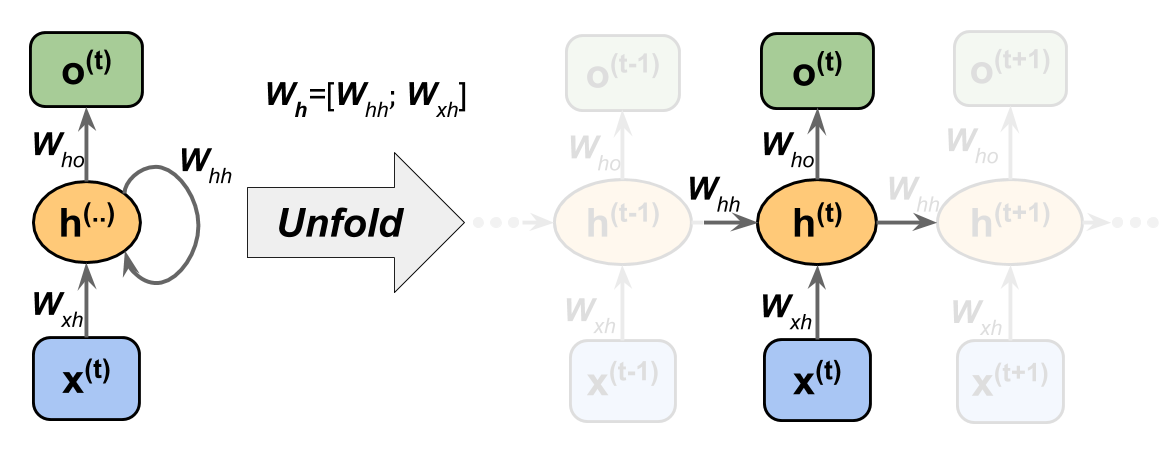

In [6]:
Image(filename='figures/15_05.png', width=700)

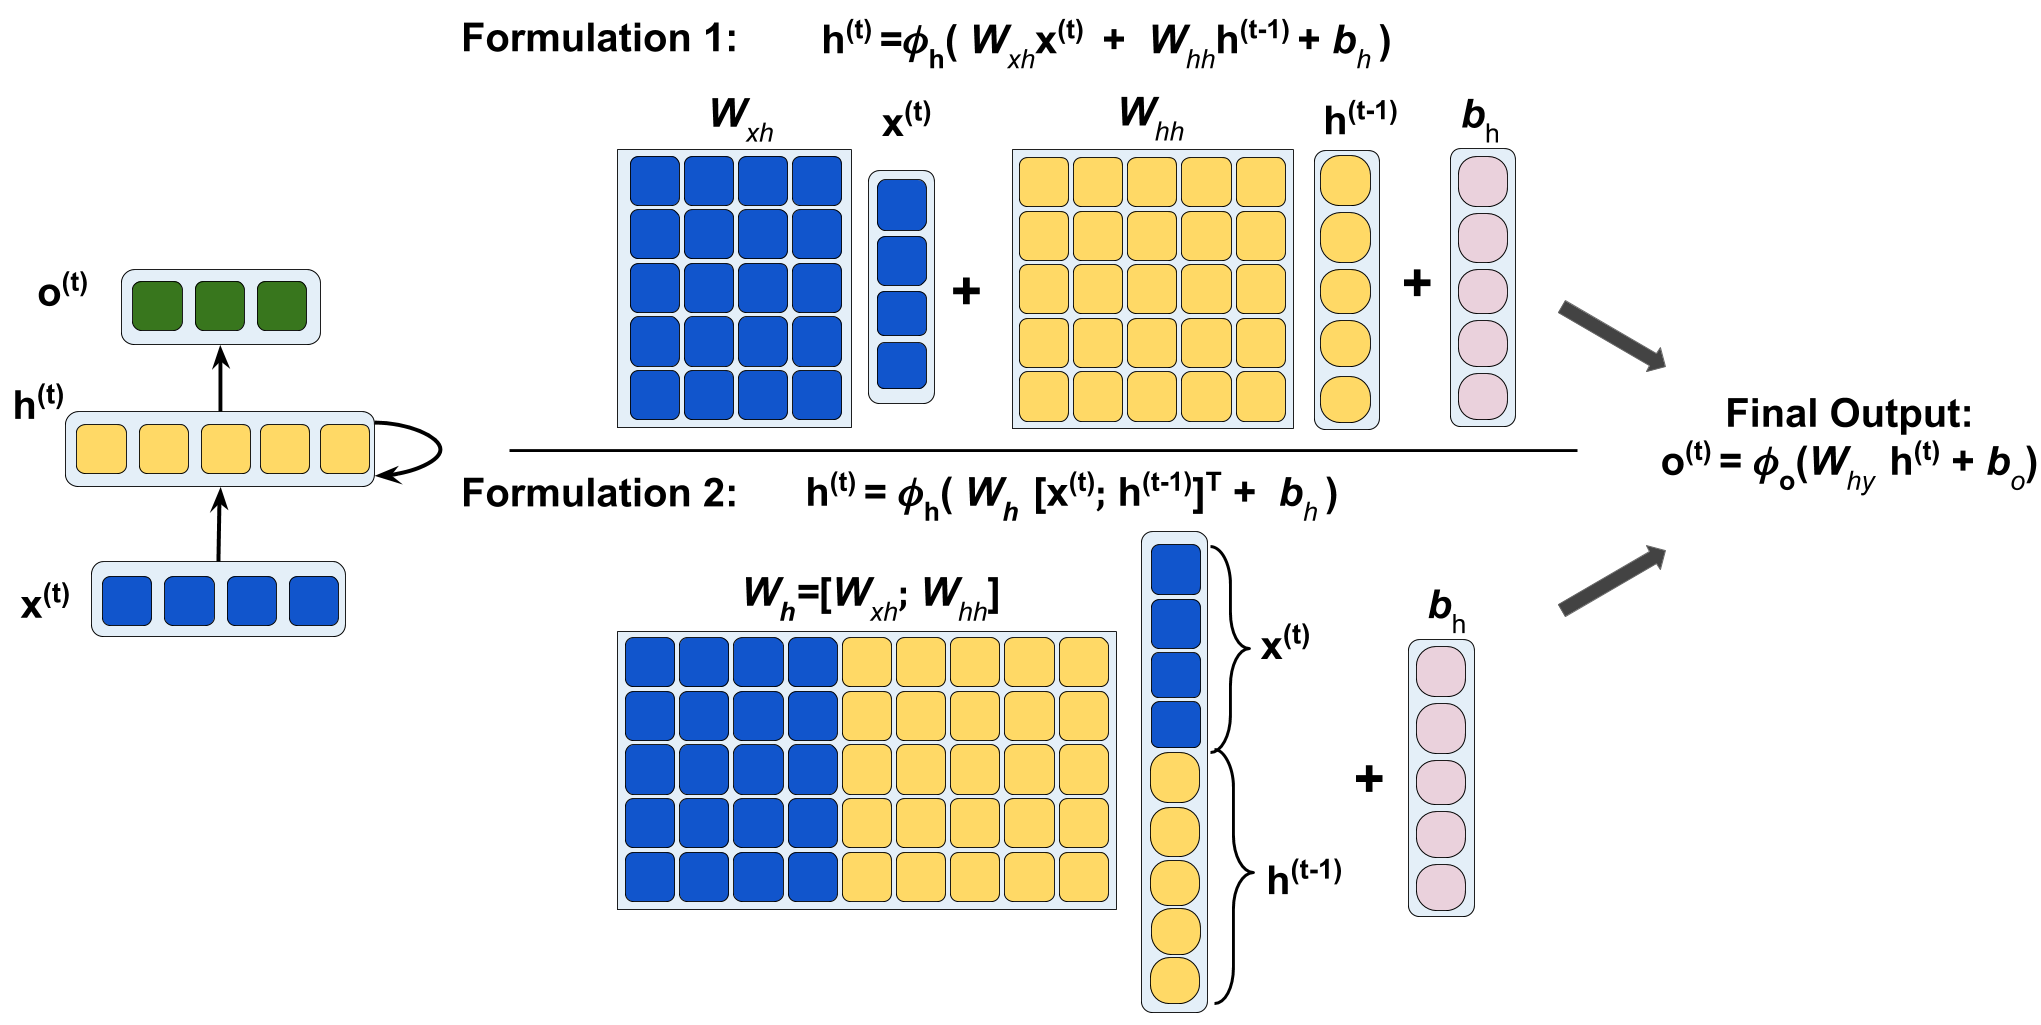

In [7]:
Image(filename='figures/15_06.png', width=700)

## Hidden-recurrence vs. output-recurrence


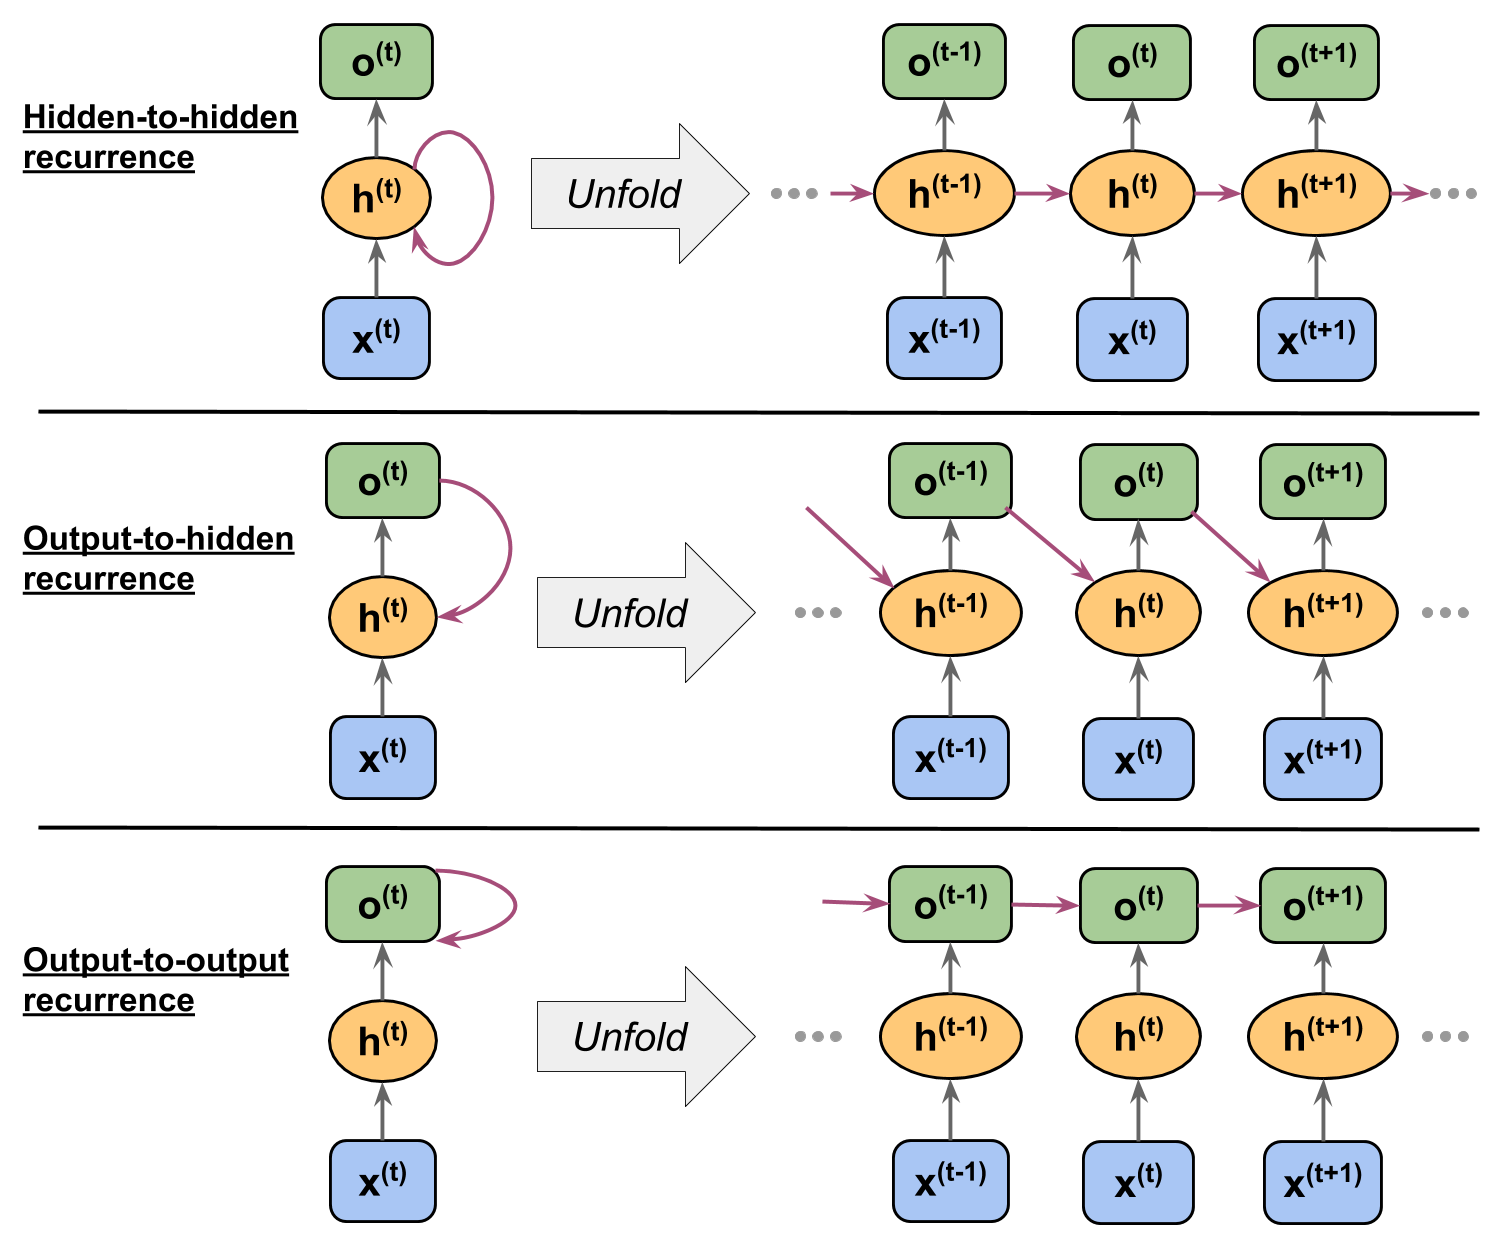

In [8]:
Image(filename='figures/15_07.png', width=700)

In [9]:
import torch
import torch.nn as nn

torch.manual_seed(1)

rnn_layer = nn.RNN(input_size=5, hidden_size=2, num_layers=1, batch_first=True)

w_xh = rnn_layer.weight_ih_l0
w_hh = rnn_layer.weight_hh_l0
b_xh = rnn_layer.bias_ih_l0
b_hh = rnn_layer.bias_hh_l0

print(f'W_xh shape: {w_xh.shape}')
print(f'W_hh shape: {w_hh.shape}')
print(f'b_xh shape: {b_xh.shape}')
print(f'b_hh shape: {b_hh.shape}')

W_xh shape: torch.Size([2, 5])
W_hh shape: torch.Size([2, 2])
b_xh shape: torch.Size([2])
b_hh shape: torch.Size([2])


In [10]:
x_seq = torch.tensor([[1.0] * 5, [2.0] * 5, [3.0] * 5]).float()

## output of the simple RNN:
output, hn = rnn_layer(torch.reshape(x_seq, (1, 3, 5)))

## manually computing the output:
out_man = []
for t in range(3):
    xt = torch.reshape(x_seq[t], (1, 5))
    print(f'Time step {t} =>')
    print(f'   Input           : {xt.numpy()}')

    ht = torch.matmul(xt, torch.transpose(w_xh, 0, 1)) + b_hh
    print(f'   Hidden          : {ht.detach().numpy()}')

    if t > 0:
        prev_h = out_man[t - 1]
    else:
        prev_h = torch.zeros((ht.shape))

    ot = ht + torch.matmul(prev_h, torch.transpose(w_hh, 0, 1)) + b_hh
    ot = torch.tanh(ot)
    out_man.append(ot)
    print(f'   Output (manual) : {ot.detach().numpy()}')
    print(f'   RNN output      : {output[:, t].detach().numpy()}')
    print()

Time step 0 =>
   Input           : [[1. 1. 1. 1. 1.]]
   Hidden          : [[-0.3161478   0.64722455]]
   Output (manual) : [[-0.21046415  0.56788784]]
   RNN output      : [[-0.3519801   0.52525216]]

Time step 1 =>
   Input           : [[2. 2. 2. 2. 2.]]
   Hidden          : [[-0.73478645  1.2972739 ]]
   Output (manual) : [[-0.5741978  0.7945334]]
   RNN output      : [[-0.68424344  0.76074266]]

Time step 2 =>
   Input           : [[3. 3. 3. 3. 3.]]
   Hidden          : [[-1.153425   1.9473232]]
   Output (manual) : [[-0.8130059   0.91817397]]
   RNN output      : [[-0.8649416   0.90466356]]



## The challenges of learning long-range interactions


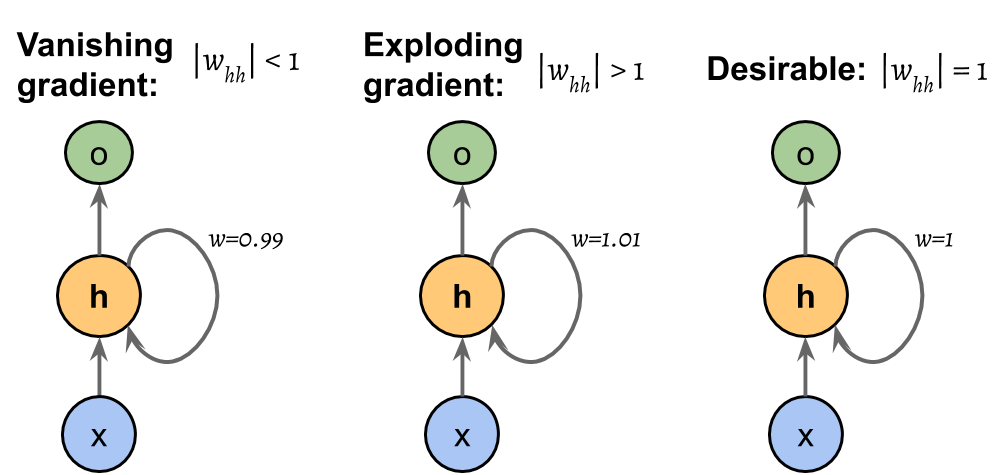

In [11]:
Image(filename='figures/15_08.png', width=700)

## Long Short-Term Memory cells


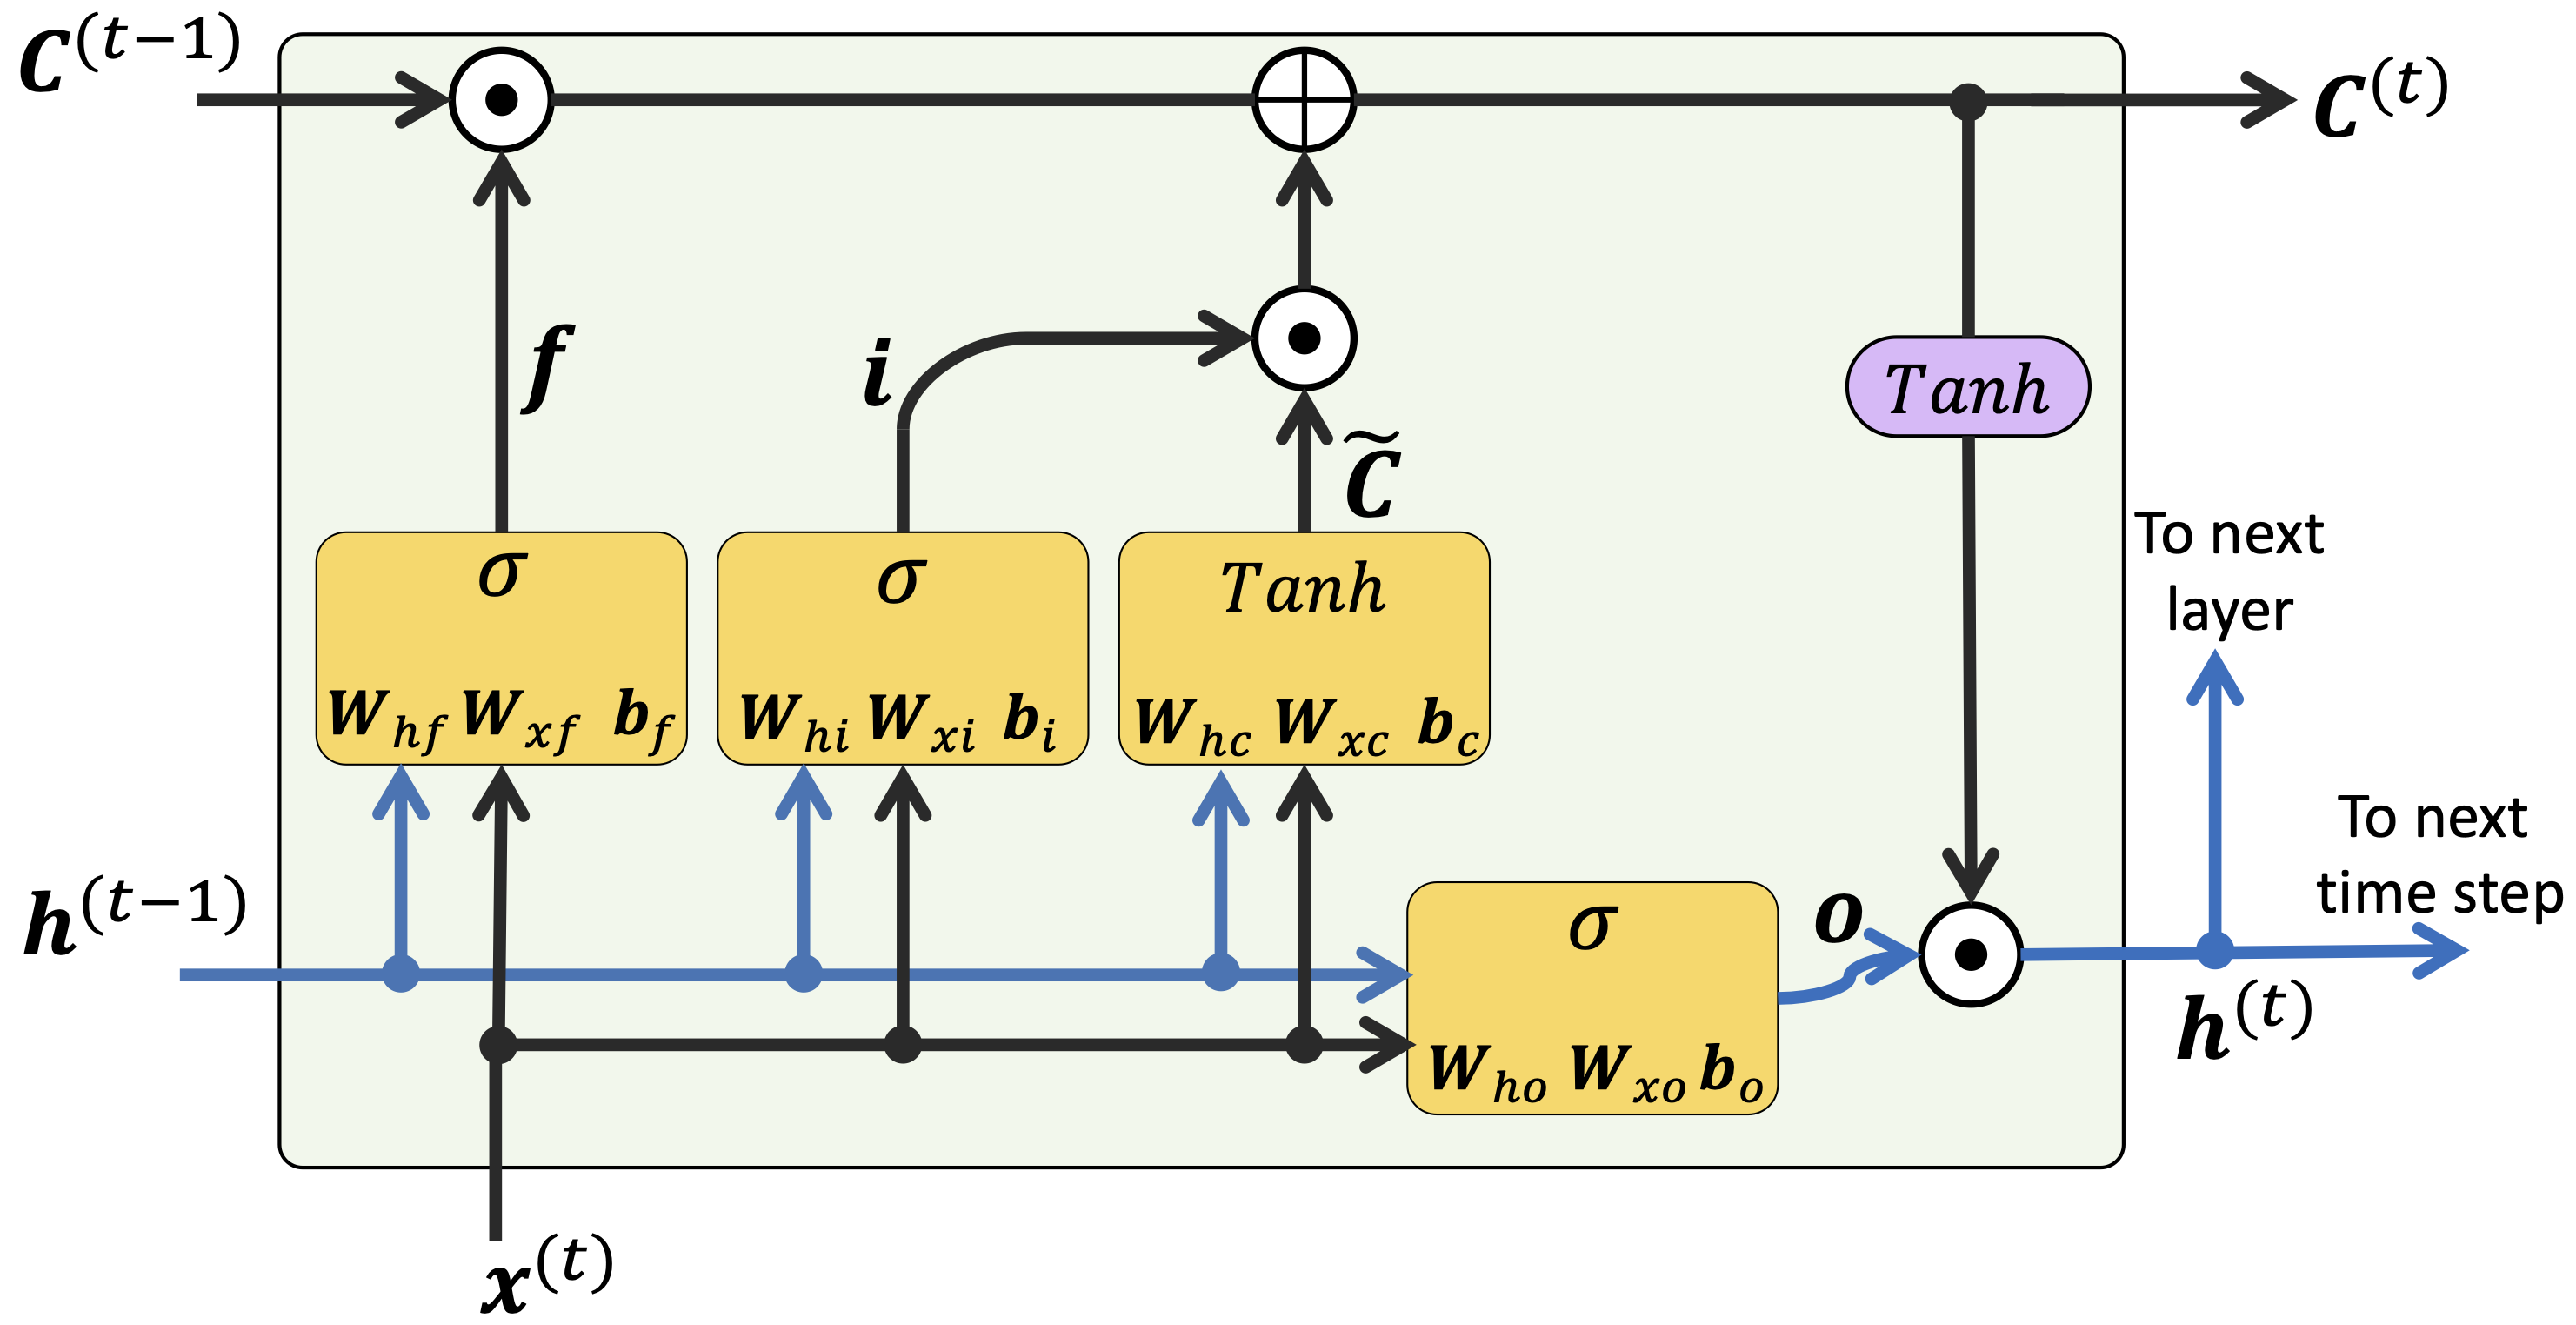

In [12]:
Image(filename='figures/15_09.png', width=700)

# Implementing RNNs for sequence modeling in PyTorch

## Project one: predicting the sentiment of IMDb movie reviews

### Preparing the movie review data


In [13]:
import torch
import torch.nn as nn

In [15]:
from torchtext.datasets import IMDB
from torch.utils.data.dataset import random_split

# Step 1: load and create the datasets

train_dataset = IMDB(split='train')
test_dataset = IMDB(split='test')

torch.manual_seed(1)
train_dataset, valid_dataset = random_split(list(train_dataset), [20000, 5000])

ModuleNotFoundError: No module named 'torchtext'

In [ ]:
## Step 2: find unique tokens (words)
import re
from collections import Counter, OrderedDict

token_counts = Counter()


def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = text.split()
    return tokenized


for label, line in train_dataset:
    tokens = tokenizer(line)
    token_counts.update(tokens)

print(f'Vocab-size: {len(token_counts)}')

Vocab-size: 69023


In [ ]:
## Step 3: encoding each unique token into integers
from torchtext.vocab import vocab

sorted_by_freq_tuples = sorted(token_counts.items(),
                               key=lambda x: x[1],
                               reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[11, 7, 35, 457]


In [ ]:
## Step 3-A: define the functions for transformation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]
label_pipeline = lambda x: 1. if x == 'pos' else 0.


## Step 3-B: wrap the encode and transformation function
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(
        device)

In [ ]:
## Take a small batch

from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset,
                        batch_size=4,
                        shuffle=False,
                        collate_fn=collate_batch)
text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[   35,  1739,     7,   449,   721,     6,   301,     4,   787,     9,
             4,    18,    44,     2,  1705,  2460,   186,    25,     7,    24,
           100,  1874,  1739,    25,     7, 34415,  3568,  1103,  7517,   787,
             5,     2,  4991, 12401,    36,     7,   148,   111,   939,     6,
         11598,     2,   172,   135,    62,    25,  3199,  1602,     3,   928,
          1500,     9,     6,  4601,     2,   155,    36,    14,   274,     4,
         42945,     9,  4991,     3,    14, 10296,    34,  3568,     8,    51,
           148,    30,     2,    58,    16,    11,  1893,   125,     6,   420,
          1214,    27, 14542,   940,    11,     7,    29,   951,    18,    17,
         15994,   459,    34,  2480, 15211,  3713,     2,   840,  3200,     9,
          3568,    13,   107,     9,   175,    94,    25,    51, 10297,  1796,
            27,   712,    16,     2,   220,    17,     4,    54,   722,   238,
           395,     2,   787,    32,    27,  5236,  

In [ ]:
## Step 4: batching the datasets

batch_size = 32

train_dl = DataLoader(train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset,
                      batch_size=batch_size,
                      shuffle=False,
                      collate_fn=collate_batch)
test_dl = DataLoader(test_dataset,
                     batch_size=batch_size,
                     shuffle=False,
                     collate_fn=collate_batch)

### Embedding layers for sentence encoding

- `input_dim`: number of words, i.e. maximum integer index + 1.
- `output_dim`:
- `input_length`: the length of (padded) sequence

  - for example, `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`  
    => input_lenght is 10

- When calling the layer, takes integr values as input,  
  the embedding layer convert each interger into float vector of size `[output_dim]`
  - If input shape is `[BATCH_SIZE]`, output shape will be `[BATCH_SIZE, output_dim]`
  - If input shape is `[BATCH_SIZE, 10]`, output shape will be `[BATCH_SIZE, 10, output_dim]`


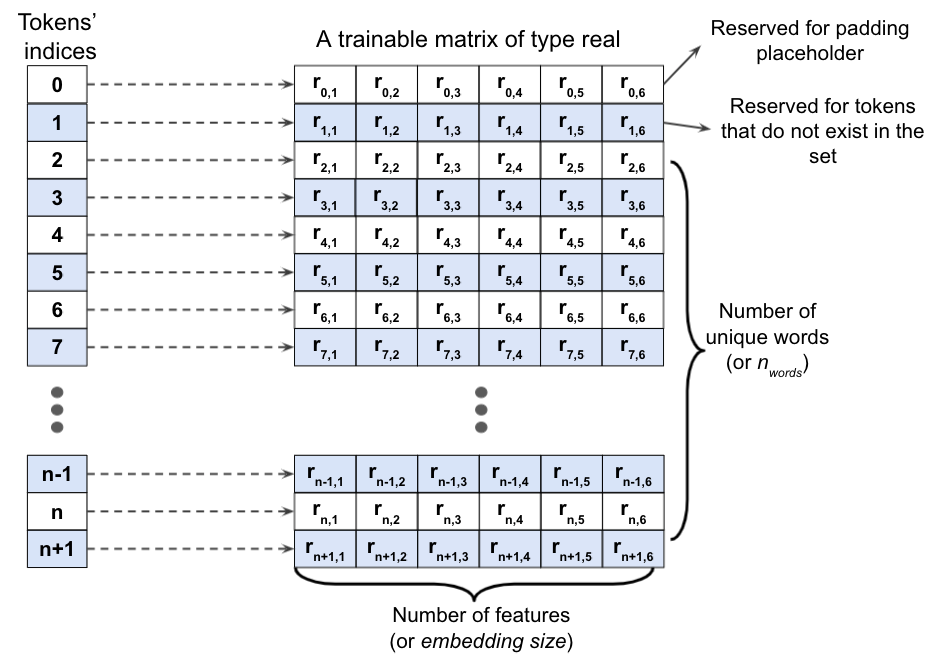

In [ ]:
Image(filename='figures/15_10.png', width=700)

In [ ]:
embedding = nn.Embedding(num_embeddings=10, embedding_dim=3, padding_idx=0)

# a batch of 2 samples of 4 indices each
text_encoded_input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 0]])
print(embedding(text_encoded_input))

tensor([[[ 0.7039, -0.8321, -0.4651],
         [-0.3203,  2.2408,  0.5566],
         [-0.4643,  0.3046,  0.7046],
         [-0.7106, -0.2959,  0.8356]],

        [[-0.4643,  0.3046,  0.7046],
         [ 0.0946, -0.3531,  0.9124],
         [-0.3203,  2.2408,  0.5566],
         [ 0.0000,  0.0000,  0.0000]]], grad_fn=<EmbeddingBackward0>)


### Building an RNN model

- **RNN layers:**
  - `nn.RNN(input_size, hidden_size, num_layers=1)`
  - `nn.LSTM(..)`
  - `nn.GRU(..)`
  - `nn.RNN(input_size, hidden_size, num_layers=1, bidirectional=True)`


In [ ]:
## An example of building a RNN model
## with simple RNN layer


# Fully connected neural network with one hidden layer
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size,
                          hidden_size,
                          num_layers=2,
                          batch_first=True)
        #self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out


model = RNN(64, 32)
print(model)
model(torch.randn(5, 3, 64))

RNN(
  (rnn): RNN(64, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[ 0.3183],
        [ 0.1230],
        [ 0.1772],
        [-0.1052],
        [-0.1259]], grad_fn=<AddmmBackward0>)

### Building an RNN model for the sentiment analysis task


In [ ]:
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out,
                                                lengths.cpu().numpy(),
                                                enforce_sorted=False,
                                                batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


vocab_size = len(vocab)
embed_dim = 20
rnn_hidden_size = 64
fc_hidden_size = 64

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model = model.to(device)

In [ ]:
def train(dataloader):
    model.train()
    total_acc, total_loss = 0, 0
    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        pred = model(text_batch, lengths)[:, 0]
        loss = loss_fn(pred, label_batch)
        loss.backward()
        optimizer.step()
        total_acc += ((pred >=
                       0.5).float() == label_batch).float().sum().item()
        total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(
        dataloader.dataset)


def evaluate(dataloader):
    model.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            pred = model(text_batch, lengths)[:, 0]
            loss = loss_fn(pred, label_batch)
            total_acc += ((pred >=
                           0.5).float() == label_batch).float().sum().item()
            total_loss += loss.item() * label_batch.size(0)
    return total_acc / len(dataloader.dataset), total_loss / len(
        dataloader.dataset)


In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

torch.manual_seed(1)

for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(
        f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}'
    )

Epoch 0 accuracy: 0.5605 val_accuracy: 0.5928
Epoch 1 accuracy: 0.6868 val_accuracy: 0.7134
Epoch 2 accuracy: 0.8153 val_accuracy: 0.8168
Epoch 3 accuracy: 0.8735 val_accuracy: 0.8434
Epoch 4 accuracy: 0.9075 val_accuracy: 0.8514
Epoch 5 accuracy: 0.9306 val_accuracy: 0.8624
Epoch 6 accuracy: 0.9482 val_accuracy: 0.8426
Epoch 7 accuracy: 0.9636 val_accuracy: 0.8524
Epoch 8 accuracy: 0.9720 val_accuracy: 0.8664
Epoch 9 accuracy: 0.9832 val_accuracy: 0.8658


In [ ]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}')

test_accuracy: 0.8598


#### More on the bidirectional RNN


- **Trying bidirectional recurrent layer**


In [ ]:
class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.LSTM(embed_dim,
                           rnn_hidden_size,
                           batch_first=True,
                           bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size * 2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out,
                                                lengths.cpu().numpy(),
                                                enforce_sorted=False,
                                                batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out


torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size)
model = model.to(device)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

num_epochs = 10

torch.manual_seed(1)

for epoch in range(num_epochs):
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    print(
        f'Epoch {epoch} accuracy: {acc_train:.4f} val_accuracy: {acc_valid:.4f}'
    )

Epoch 0 accuracy: 0.6067 val_accuracy: 0.5418
Epoch 1 accuracy: 0.7104 val_accuracy: 0.7012
Epoch 2 accuracy: 0.8063 val_accuracy: 0.8240
Epoch 3 accuracy: 0.8924 val_accuracy: 0.8626
Epoch 4 accuracy: 0.9365 val_accuracy: 0.8658
Epoch 5 accuracy: 0.9594 val_accuracy: 0.8670
Epoch 6 accuracy: 0.9767 val_accuracy: 0.8692
Epoch 7 accuracy: 0.9863 val_accuracy: 0.8684
Epoch 8 accuracy: 0.9914 val_accuracy: 0.8430
Epoch 9 accuracy: 0.9931 val_accuracy: 0.8782


In [ ]:
test_dataset = IMDB(split='test')
test_dl = DataLoader(test_dataset,
                     batch_size=batch_size,
                     shuffle=False,
                     collate_fn=collate_batch)

In [ ]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}')

test_accuracy: 0.8566


## Project two: character-level language modeling in PyTorch


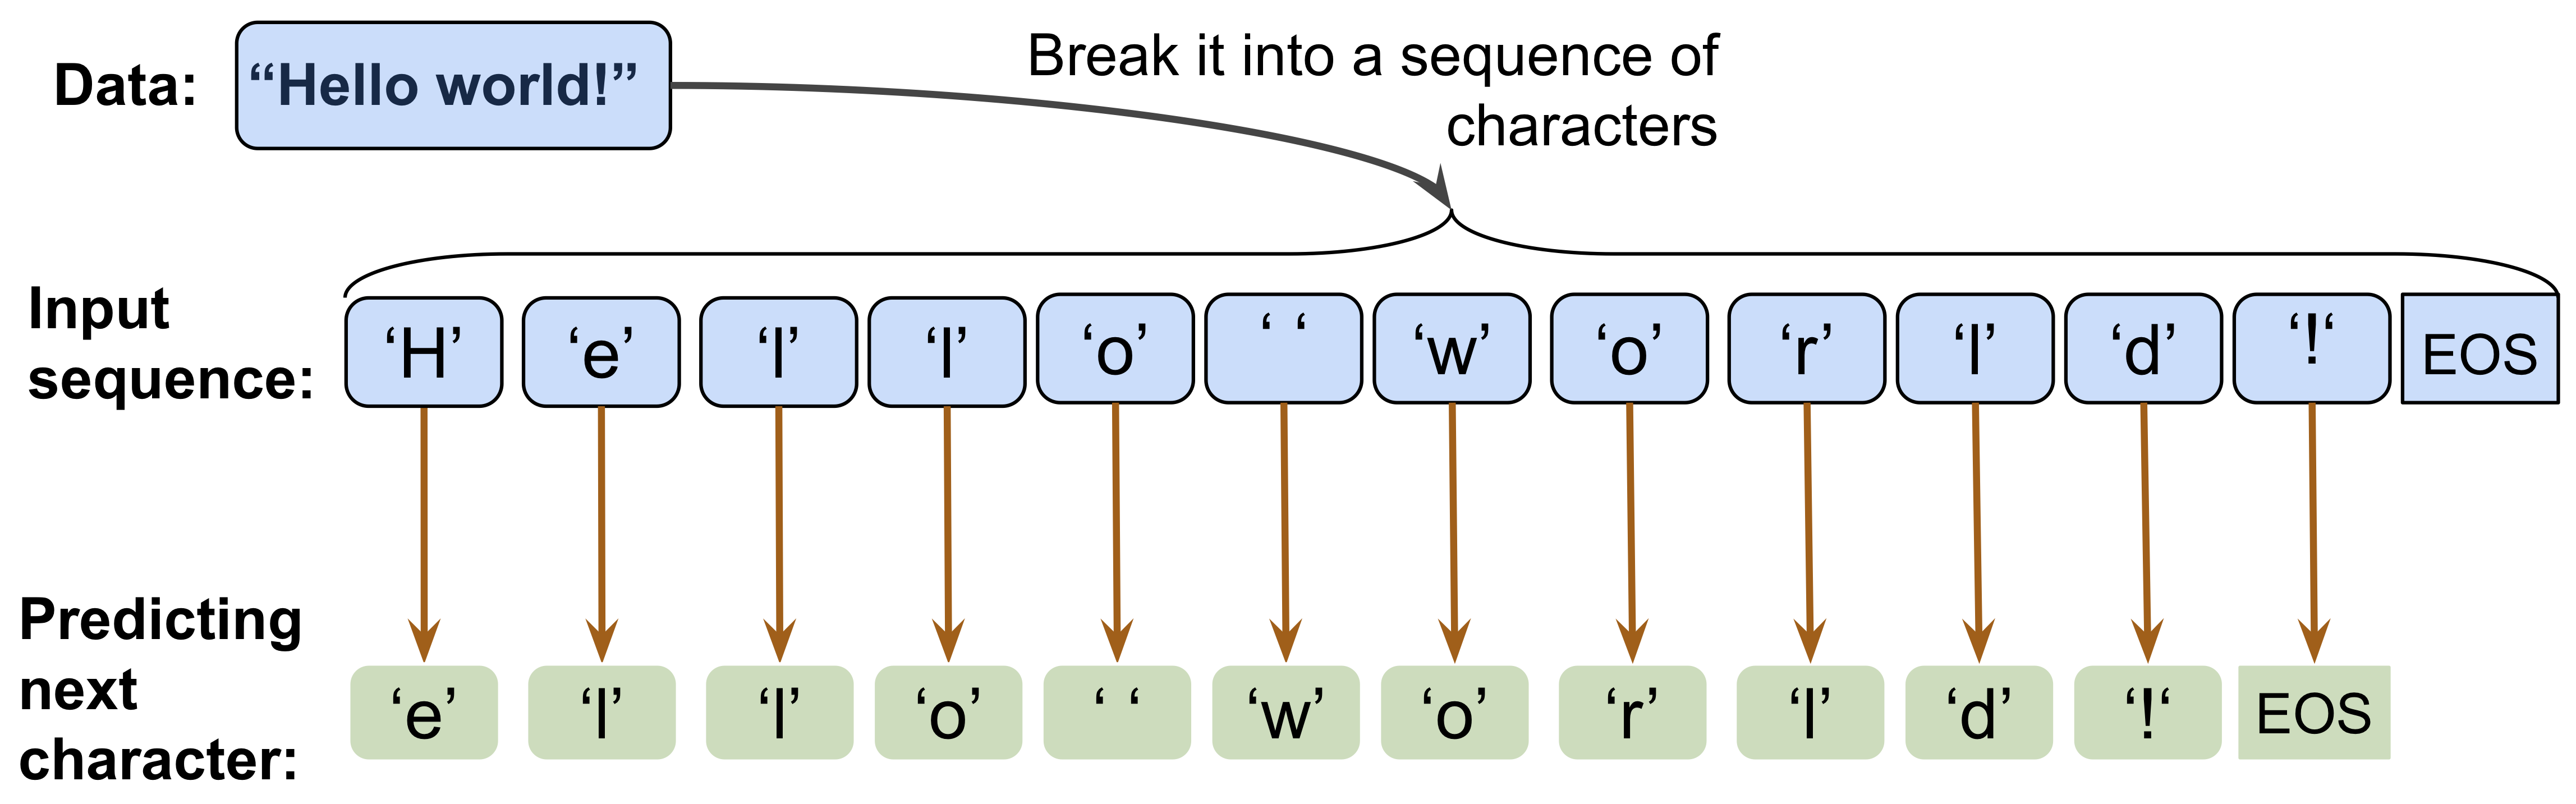

In [ ]:
Image(filename='figures/15_11.png', width=700)

### Preprocessing the dataset


In [ ]:
import numpy as np

## Reading and processing text
with open('1268-0.txt', 'r', encoding="utf8") as fp:
    text = fp.read()

start_indx = text.find('THE MYSTERIOUS ISLAND')
end_indx = text.find('End of the Project Gutenberg')

text = text[start_indx:end_indx]
char_set = set(text)
print(f'Total Length: {len(text)}')
print(f'Unique Characters: {len(char_set)}')

Total Length: 1112350
Unique Characters: 80


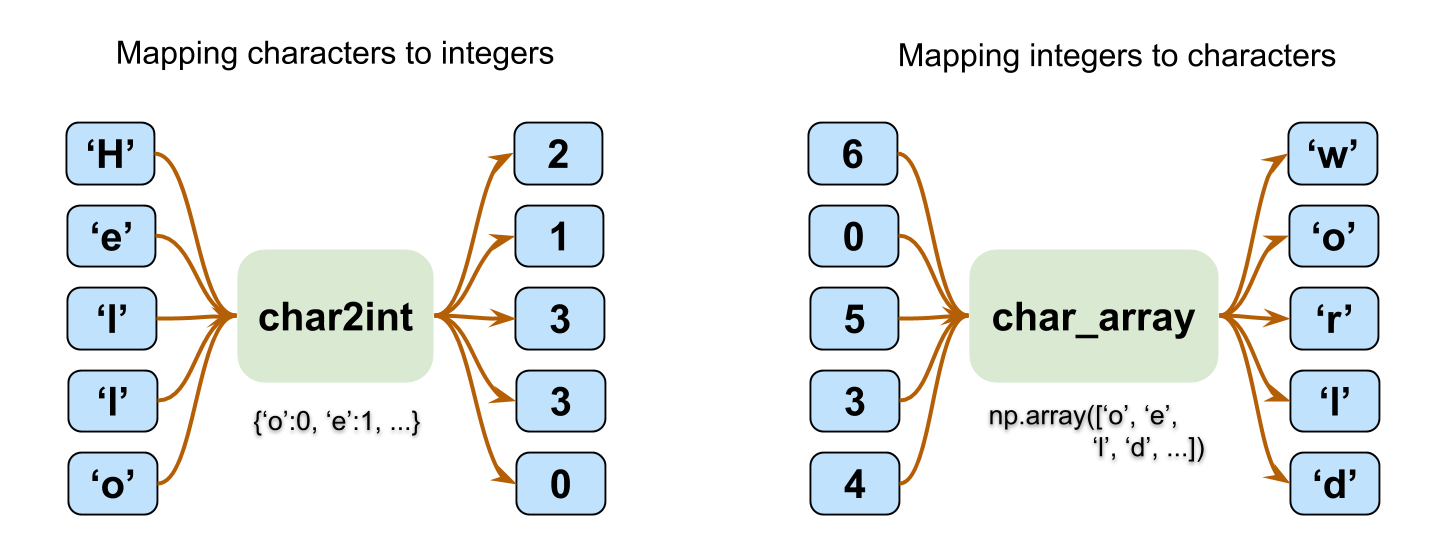

In [ ]:
Image(filename='figures/15_12.png', width=700)

In [ ]:
chars_sorted = sorted(char_set)
char2int = {ch: i for i, ch in enumerate(chars_sorted)}
char_array = np.array(chars_sorted)

text_encoded = np.array([char2int[ch] for ch in text], dtype=np.int32)

print(f'Text encoded shape: {text_encoded.shape}')
print(f"{text[:15]}    == Encoding ==> {text_encoded[:15]}")
print(text_encoded[15:21], ' == Reverse  ==> ',
      ''.join(char_array[text_encoded[15:21]]))

Text encoded shape:  (1112350,)
THE MYSTERIOUS       == Encoding ==>  [44 32 29  1 37 48 43 44 29 42 33 39 45 43  1]
[33 43 36 25 38 28]  == Reverse  ==>  ISLAND


In [ ]:
for ex in text_encoded[:5]:
    print('{} -> {}'.format(ex, char_array[ex]))

44 -> T
32 -> H
29 -> E
1 ->  
37 -> M


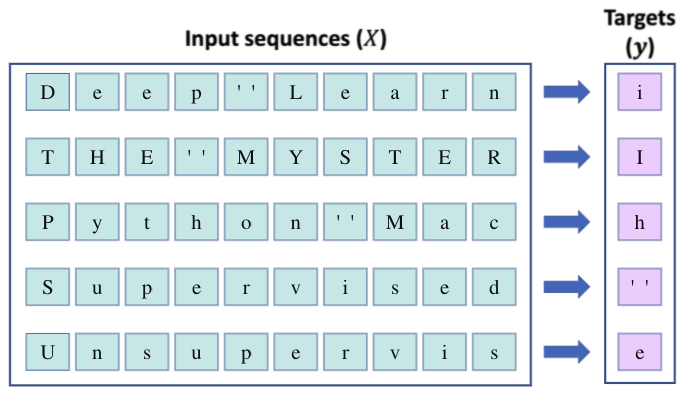

In [ ]:
Image(filename='figures/15_13.png', width=700)

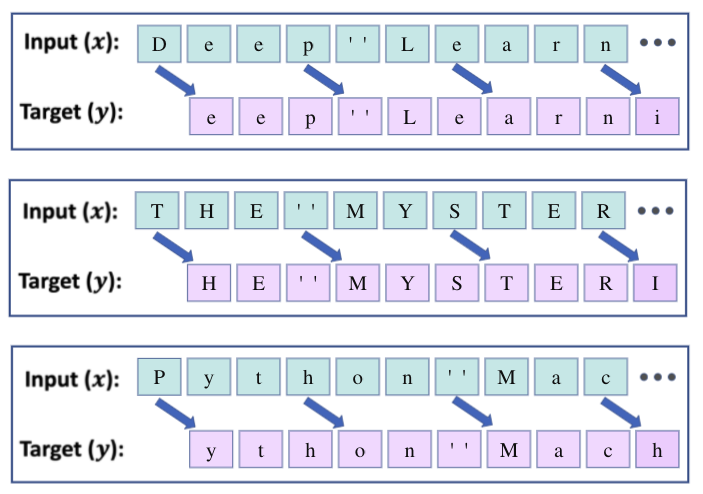

In [ ]:
Image(filename='figures/15_14.png', width=700)

In [ ]:
seq_length = 40
chunk_size = seq_length + 1

text_chunks = [
    text_encoded[i:i + chunk_size]
    for i in range(len(text_encoded) - chunk_size)
]

## inspection:
for seq in text_chunks[:1]:
    input_seq = seq[:seq_length]
    target = seq[seq_length]
    print(f"{input_seq} -> {target}")
    print(repr(''.join(char_array[input_seq])), ' -> ',
          repr(''.join(char_array[target])))

[44 32 29  1 37 48 43 44 29 42 33 39 45 43  1 33 43 36 25 38 28  1  6  6
  6  0  0  0  0  0 40 67 64 53 70 52 54 53  1 51]  ->  74
'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'  ->  'y'


In [ ]:
import torch
from torch.utils.data import Dataset


class TextDataset(Dataset):

    def __init__(self, text_chunks):
        self.text_chunks = text_chunks

    def __len__(self):
        return len(self.text_chunks)

    def __getitem__(self, idx):
        text_chunk = self.text_chunks[idx]
        return text_chunk[:-1].long(), text_chunk[1:].long()


seq_dataset = TextDataset(torch.tensor(text_chunks))

In [ ]:
for i, (seq, target) in enumerate(seq_dataset):
    print(f' Input (x): {repr("".join(char_array[seq]))}')
    print(f'Target (y): {repr("".join(char_array[target]))}')
    print()
    if i == 1:
        break

 Input (x): 'THE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced b'
Target (y): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'

 Input (x): 'HE MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by'
Target (y): 'E MYSTERIOUS ISLAND ***\n\n\n\n\nProduced by '



In [ ]:
device = torch.device("cuda:0")
# device = 'cpu'

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

torch.manual_seed(1)
seq_dl = DataLoader(seq_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    drop_last=True)


### Building a character-level RNN model


In [ ]:
import torch.nn as nn


class RNN(nn.Module):

    def __init__(self, vocab_size, embed_dim, rnn_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, batch_first=True)
        self.fc = nn.Linear(rnn_hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        out = self.embedding(x).unsqueeze(1)
        out, (hidden, cell) = self.rnn(out, (hidden, cell))
        out = self.fc(out).reshape(out.size(0), -1)
        return out, hidden, cell

    def init_hidden(self, batch_size):
        hidden = torch.zeros(1, batch_size, self.rnn_hidden_size)
        cell = torch.zeros(1, batch_size, self.rnn_hidden_size)
        return hidden.to(device), cell.to(device)


vocab_size = len(char_array)
embed_dim = 256
rnn_hidden_size = 512

torch.manual_seed(1)
model = RNN(vocab_size, embed_dim, rnn_hidden_size)
model = model.to(device)
model

RNN(
  (embedding): Embedding(80, 256)
  (rnn): LSTM(256, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=80, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10000

torch.manual_seed(1)

for epoch in range(num_epochs):
    hidden, cell = model.init_hidden(batch_size)
    seq_batch, target_batch = next(iter(seq_dl))
    seq_batch = seq_batch.to(device)
    target_batch = target_batch.to(device)
    optimizer.zero_grad()
    loss = 0
    for c in range(seq_length):
        pred, hidden, cell = model(seq_batch[:, c], hidden, cell)
        loss += loss_fn(pred, target_batch[:, c])
    loss.backward()
    optimizer.step()
    loss = loss.item() / seq_length
    if epoch % 500 == 0:
        print(f'Epoch {epoch} loss: {loss:.4f}')

Epoch 0 loss: 4.3719
Epoch 500 loss: 3.0626
Epoch 1000 loss: 3.0635
Epoch 1500 loss: 3.1011
Epoch 2000 loss: 3.0409
Epoch 2500 loss: 3.0556
Epoch 3000 loss: 3.0772
Epoch 3500 loss: 3.1016
Epoch 4000 loss: 3.0059
Epoch 4500 loss: 3.0568
Epoch 5000 loss: 3.0857
Epoch 5500 loss: 3.0614
Epoch 6000 loss: 3.0814
Epoch 6500 loss: 3.0733
Epoch 7000 loss: 3.0303
Epoch 7500 loss: 3.0621
Epoch 8000 loss: 3.0873
Epoch 8500 loss: 3.0368
Epoch 9000 loss: 3.0449
Epoch 9500 loss: 3.0564


### Evaluation phase: generating new text passages


In [ ]:
from torch.distributions.categorical import Categorical

torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 1.0]])

print(f'Probabilities: {nn.functional.softmax(logits, dim=1).numpy()[0]}')

m = Categorical(logits=logits)
samples = m.sample((10, ))
print(samples.numpy())

Probabilities: [0.33333334 0.33333334 0.33333334]
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [2]
 [1]
 [1]]


In [ ]:
torch.manual_seed(1)

logits = torch.tensor([[1.0, 1.0, 3.0]])

print(f'Probabilities: {nn.functional.softmax(logits, dim=1).numpy()[0]}')

m = Categorical(logits=logits)
samples = m.sample((10, ))
print(samples.numpy())

Probabilities: [0.10650698 0.10650698 0.78698605]
[[0]
 [2]
 [2]
 [1]
 [2]
 [1]
 [2]
 [2]
 [2]
 [2]]


In [ ]:
def sample(model, starting_str, len_generated_text=500, scale_factor=1.0):

    encoded_input = torch.tensor([char2int[s] for s in starting_str])
    encoded_input = torch.reshape(encoded_input, (1, -1))

    generated_str = starting_str

    model.eval()
    hidden, cell = model.init_hidden(1)
    hidden = hidden.to('cpu')
    cell = cell.to('cpu')
    for c in range(len(starting_str) - 1):
        _, hidden, cell = model(encoded_input[:, c].view(1), hidden, cell)

    last_char = encoded_input[:, -1]
    for i in range(len_generated_text):
        logits, hidden, cell = model(last_char.view(1), hidden, cell)
        logits = torch.squeeze(logits, 0)
        scaled_logits = logits * scale_factor
        m = Categorical(logits=scaled_logits)
        last_char = m.sample()
        generated_str += str(char_array[last_char])

    return generated_str


torch.manual_seed(1)
model.to('cpu')
print(sample(model, starting_str='The island'))

The island aa i fojhhdoe  n.hot”tts  yseeeptw vceb,aeeeardebnaesobrht iy achegha iaienhans
auisro’oa”iehte tttweennnegvhvsv  ,ue.honwadh,fcrmoy,n vdh ,eoha a.boeyfdreamlcGanp  e r
wndhdekisunena   lh
a ee.niw kw  tocmfsioraonl eurs as
dws
asth  yre flmesneeiobseacff
bts semesreida
o d nt ia aessrsefur
rsoy suottdn ttfhlui ,  ewTnwisf nf n  pmaobowos.gWTtrrlreitgv eo gttt arhe egoh an l d
 
leuetke huhe,costth.sdihwtra“f .dc i ohin, tvnohr rt rttcoa , a g  at eeoayo,nanah y t ao” se rt masier  .sereneeo,io


- **Predictability vs. randomness**


In [ ]:
logits = torch.tensor([[1.0, 1.0, 3.0]])

print(
    f'Probabilities before scaling:        {nn.functional.softmax(logits, dim=1).numpy()[0]}'
)
print(
    f'Probabilities after scaling with 0.5: {nn.functional.softmax(0.5 * logits, dim=1).numpy()[0]}'
)
print(
    f'Probabilities after scaling with 0.1: {nn.functional.softmax(0.1 * logits, dim=1).numpy()[0]}',
)

Probabilities before scaling:         [0.10650698 0.10650698 0.78698605]
Probabilities after scaling with 0.5: [0.21194156 0.21194156 0.57611686]
Probabilities after scaling with 0.1: [0.3104238  0.3104238  0.37915248]


In [ ]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', scale_factor=2.0))

The island    e dieee l.  e eit“ssr  uoaaantt t d    ba o   h arn oes eu   ebee  e eahe hr  teoonvm “eaera ssttaaiheaetetrt   t  eiht  e e nflu i t e  die     latd n  ee   hn  a n
th e ceerthcg    ee
  aa het et  tl edoein lee btnr  r  tr  rte  toc eeebrhcael oa  de  rr paebroae  
i   hs e   arrnodetn opiu othtr h tsceete    at hteoe he h  ne n ntio e  sooeoceret al etss  ne   eie  h e     e t sea ete   ioste o eetro wd     e meeg  tthlen ns oss l      e   s aan ui h e e v t  iy r  os e reao   r oahadi em


In [ ]:
torch.manual_seed(1)
print(sample(model, starting_str='The island', scale_factor=0.5))


The island ILAi,fokghbod ,mDhow”uut1;“seeerwy?yafaBOceeasbcanSetpashu,j“.NaheghU;iNhemhJnt
Ywisrp”pM”ieite,uuvzeeonmegyhyty ;BwcFhon‘MbhAgarmp”Bo.ybh,?fohO0PFaoe“fcrcOllaGSnr, e r
ynahcekitwnemT-.0lh
L eeGoi‘7ky
7wpamfsiorToml ewrt at
byt
Otvh2 ’se;flmetneeipaseMaff
att seletrdicM
o0c.nu?iN Rdttrsffwr
rso“ sxowtbn;vufhlwj,A..d‘InzitfAnf-n -rmapaqyosFgKHtsrlsejtfy:eo gvuu,Trhc,cgog Tn l b
 
lcwcule iwhcBaostwhEsbjgytsW”f Fca,i phinA,vynphr ru!svuaoJ,A T.g, Wt!edoM“oBnImag ” w To”;td:su7mMtker,.CtcseneeoBkp


# Understanding language with the Transformer model

## Understanding the self-attention mechanism

## A basic version of self-attention


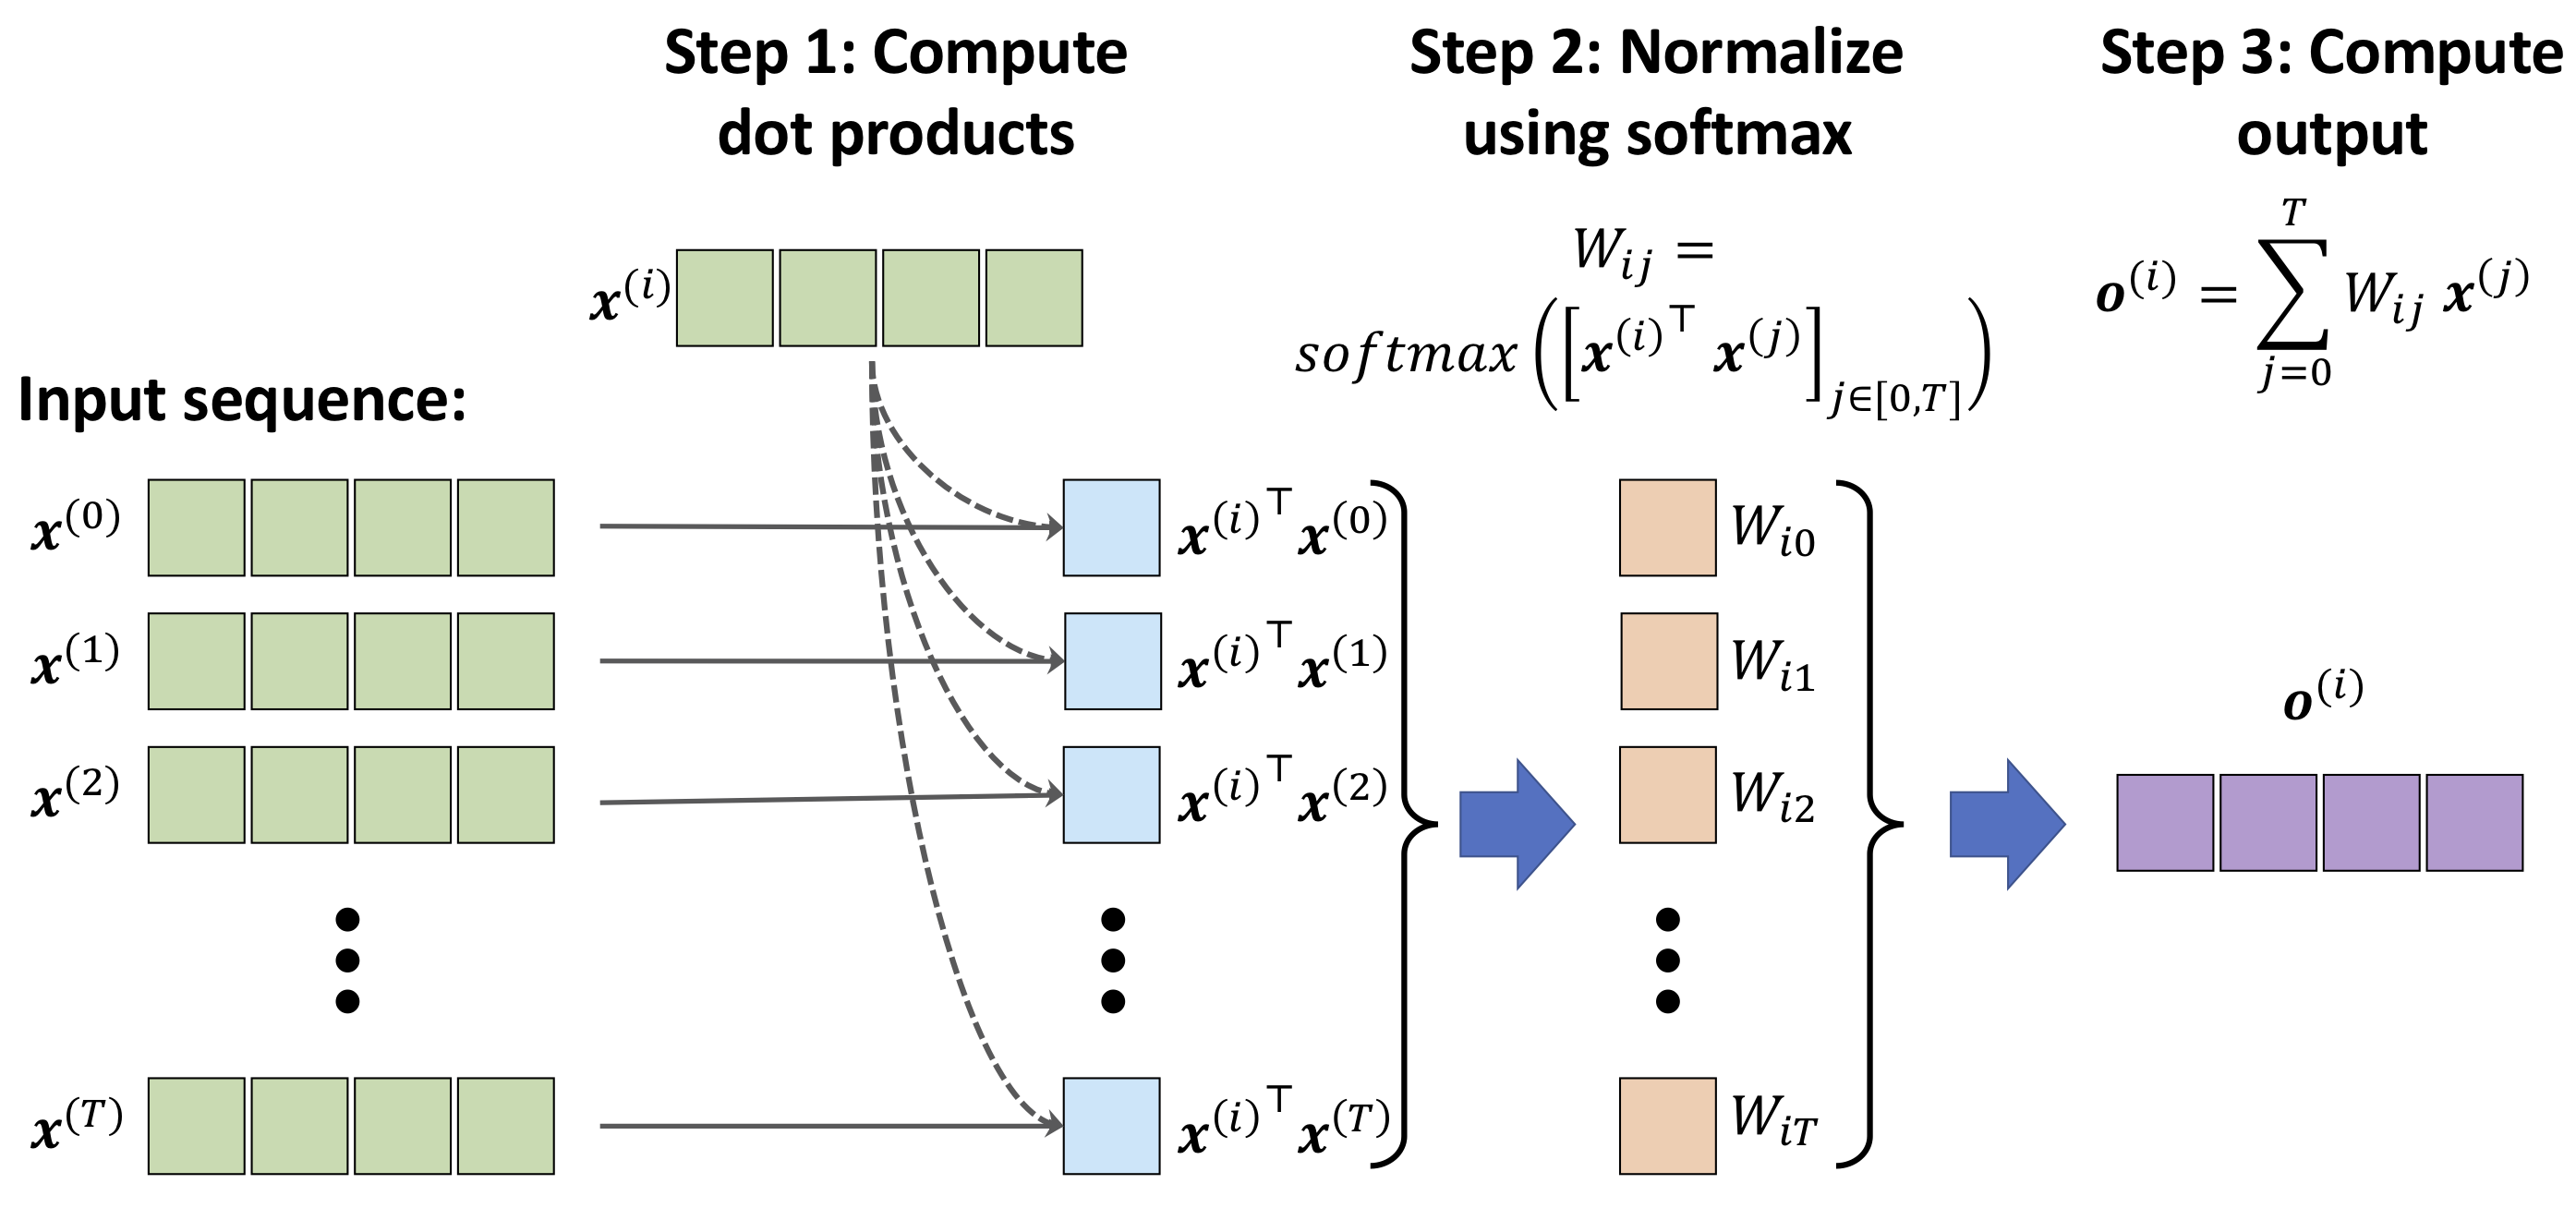

In [ ]:
Image(filename='figures/15_15.png', width=700)

### Parameterizing the self-attention mechanism with query, key, and value weights


## Multi-head attention and the Transformer block


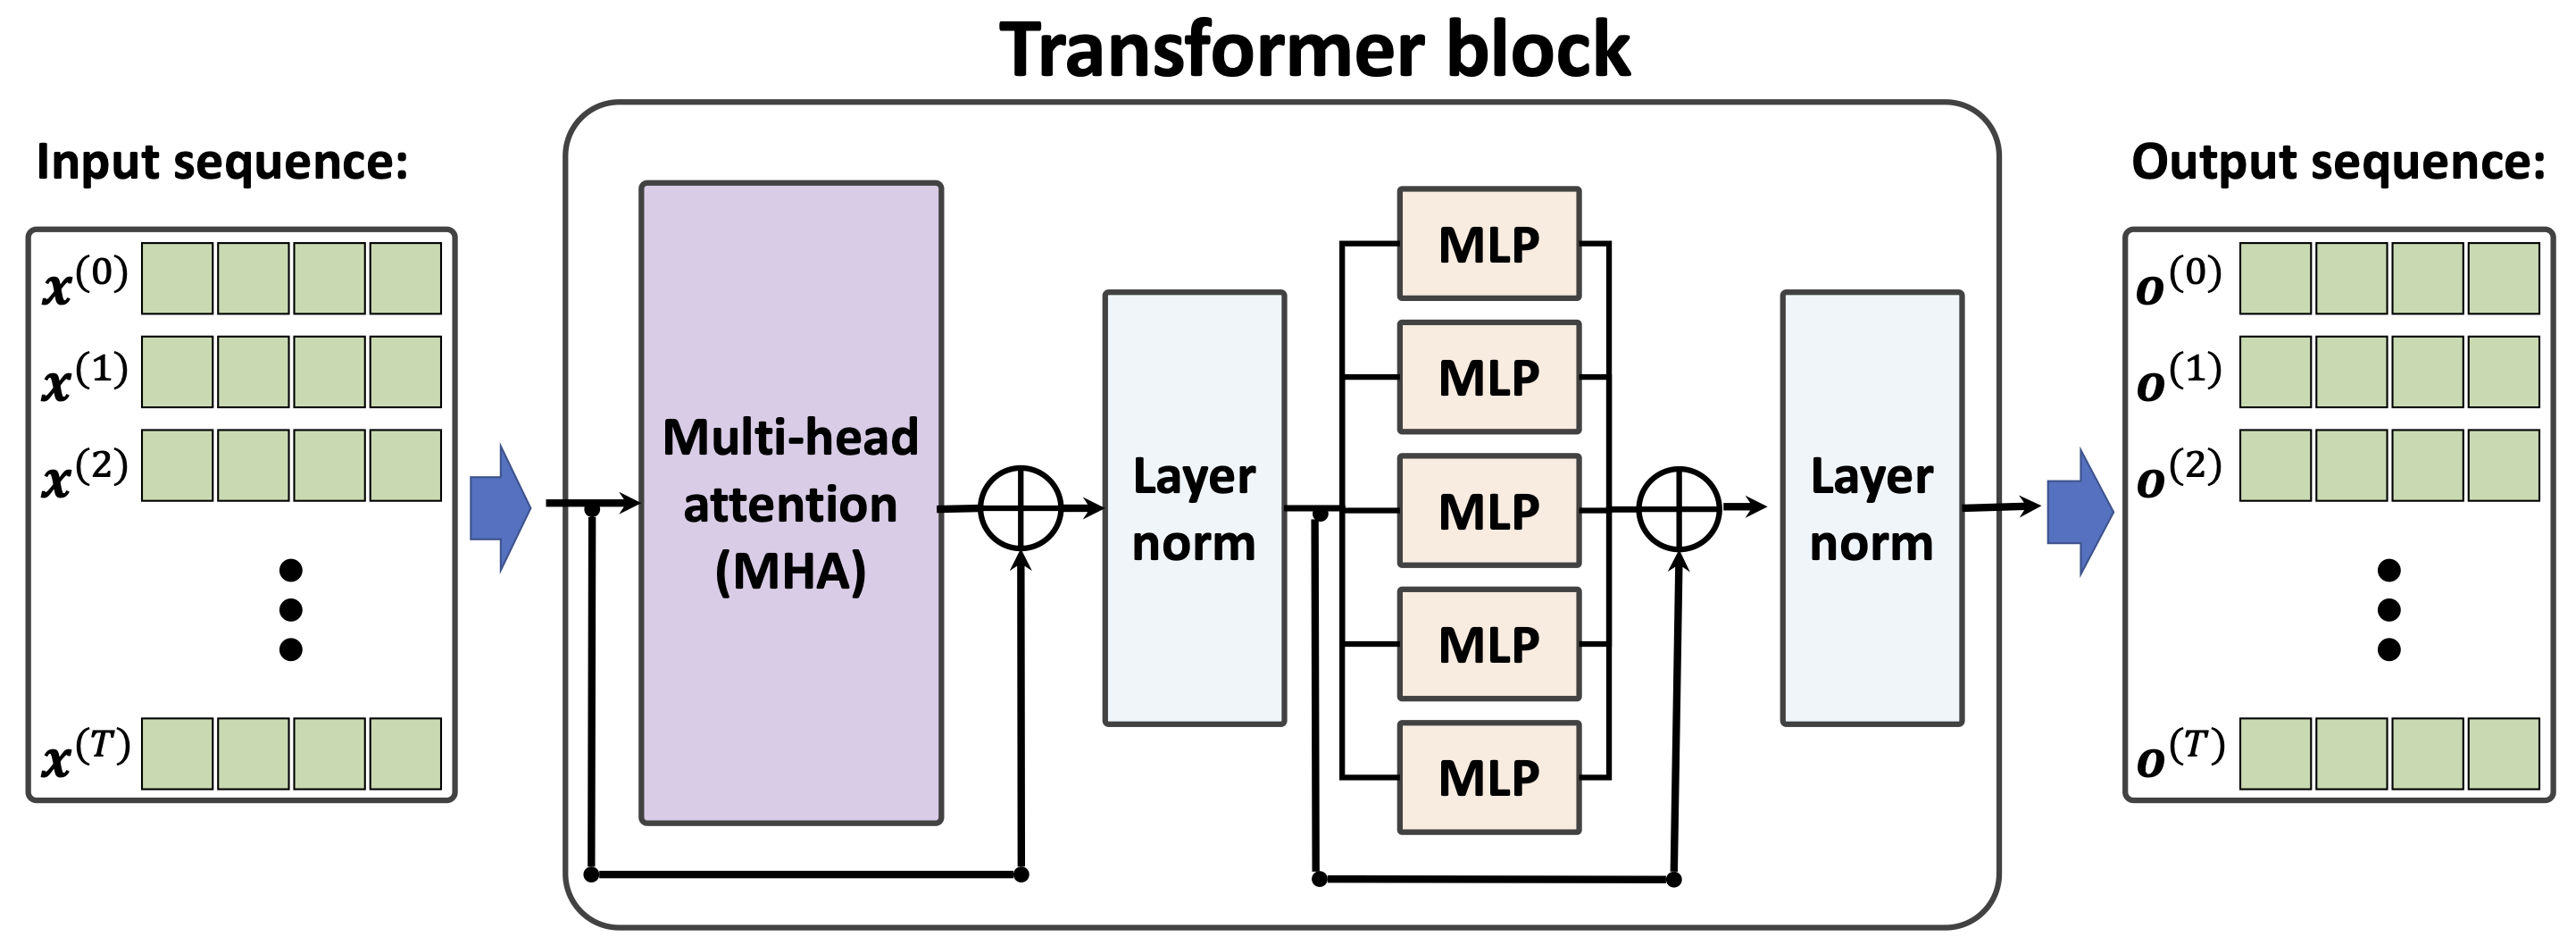

In [ ]:
Image(filename='figures/15_16.png', width=700)